<a href="https://colab.research.google.com/github/ArthurChan-1111/Bitcoin_prediction/blob/main/Master_dataset.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [1]:
!pip install pandas_ta
!pip install numpy==1.23.5
!pip install pandas

In [2]:
!git clone https://github.com/ArthurChan-1111/Bitcoin_prediction.git

%cd Bitcoin_prediction

import pandas as pd
import pandas_ta as ta
import csv
import numpy as np

btc_data = pd.read_csv('Bitcoin Historical Data.csv', on_bad_lines='skip', lineterminator='\n')
btc_data.tail(5)

fatal: destination path 'Bitcoin_prediction' already exists and is not an empty directory.
/content/Bitcoin_prediction


,Date,Price,Open,High,Low,Vol. ('000),Change %\r
4107,1/5/2014,1014.7,924.7,1029.9,911.4,21.37,9.74%\r
4108,1/4/2014,924.7,884.3,932.2,848.3,14.24,4.57%\r
4109,1/3/2014,884.3,856.9,888.2,839.4,9.71,3.19%\r
4110,1/2/2014,856.9,815.9,886.2,810.5,12.81,5.02%\r
4111,1/1/2014,815.9,805.9,829.9,771.0,10.76,1.24%


In [3]:
# Convert the dictionary to a DataFrame
btc_data = pd.DataFrame(btc_data)

# 1. Parse the "Date" column into datetime format
btc_data["Date"] = pd.to_datetime(btc_data["Date"], format="%m/%d/%Y")

# 2. Sort the data by date in ascending order
btc_data.sort_values(by="Date", ascending=True, inplace=True)

In [4]:
# Calculate RSI, EMA, SMA, and MACD
btc_data["RSI_6"] = ta.rsi(btc_data["Price"], length=6)  # Relative Strength Index
btc_data["RSI_12"] = ta.rsi(btc_data["Price"], length=12)  # Relative Strength Index
btc_data["EMA_14"] = ta.ema(btc_data["Price"], length=14)  # Exponential Moving Average
btc_data["SMA_14"] = ta.sma(btc_data["Price"], length=14)  # Simple Moving Average

# Calculate MACD
macd = ta.macd(btc_data["Price"], fast=12, slow=26, signal=9)
btc_data["MACD"] = macd["MACD_12_26_9"]
btc_data["MACD_Signal"] = macd["MACDs_12_26_9"]
btc_data["MACD_Hist"] = macd["MACDh_12_26_9"]

# Display the first few rows of the data with calculated indicators
btc_data.tail()

,Date,Price,Open,High,Low,Vol. ('000),Change %\r,RSI_6,RSI_12,EMA_14,SMA_14,MACD,MACD_Signal,MACD_Hist
4,2025-04-01,85164.2,82548.6,85506.2,82435.8,66.72,3.17%\r,55.110436,49.849551,84611.618769,85086.800000,-969.311380,-1110.845986,141.534605
3,2025-04-02,82525.0,85166.0,88377.3,82358.9,104.05,-3.10%\r,39.571214,43.207951,84333.402933,84778.514286,-1056.777802,-1100.032349,43.254547
2,2025-04-03,83159.4,82522.6,83908.9,81313.8,83.15,0.77%\r,44.116403,45.125138,84176.869208,84703.607143,-1062.655166,-1092.556912,29.901746
1,2025-04-04,83866.7,83160.2,84704.1,81691.1,91.54,0.85%\r,49.225834,47.289371,84135.513314,84688.850000,-998.727116,-1073.790953,75.063837
0,2025-04-05,83552.1,83876.0,84249.3,82384.4,32.71,-0.38%\r,46.935363,46.401387,84057.724872,84668.250000,-962.355827,-1051.503928,89.148100


In [5]:
# Calculate Bollinger Bands
bollinger_bands = ta.bbands(btc_data["Price"], length=20, std=2)
btc_data["BB_Upper"] = bollinger_bands["BBU_20_2.0"]
btc_data["BB_Middle"] = bollinger_bands["BBM_20_2.0"]
btc_data["BB_Lower"] = bollinger_bands["BBL_20_2.0"]

# Percentage difference between Bollinger Bands
btc_data["BB_Percentage"] = (
    (btc_data["BB_Upper"] - btc_data["BB_Lower"]) / btc_data["BB_Middle"])

In [6]:
# Function to clean and convert volume data
def clean_volume(volume):
    if isinstance(volume, str):  # Check if the value is a string
        volume = volume.replace(',', '')  # Remove commas
        if 'B' in volume:  # If the value contains 'B' (billions)
            return float(volume.replace('B', '')) * 1_000_000_000
        elif 'M' in volume:  # If the value contains 'M' (millions)
            return float(volume.replace('M', '')) * 1_000_000
        elif 'K' in volume:  # If the value contains 'K' (thousands)
            return float(volume.replace('K', '')) * 1_000
        else:  # If no suffix is present, convert to float directly
            return float(volume)
    return np.nan  # Handle unexpected cases

# Apply the cleaning function to the volume column
btc_data["Volume"] = btc_data["Vol. ('000)"].apply(clean_volume)

In [7]:
# Add On-Balance Volume (OBV)
btc_data["OBV"] = ta.obv(btc_data["Price"], btc_data["Volume"])

In [8]:
# Day of the week (0=Monday, 6=Sunday)
btc_data["Day_of_Week"] = btc_data["Date"].dt.dayofweek

# Week of the year
btc_data["Week_of_Year"] = btc_data["Date"].dt.isocalendar().week

# Month of the year
btc_data["Month"] = btc_data["Date"].dt.month

# Quarter of the year
btc_data["Quarter"] = btc_data["Date"].dt.quarter

# Year
btc_data["Year"] = btc_data["Date"].dt.year

In [9]:
# Support and Resistance Levels
btc_data["Support"] = btc_data["Low"].rolling(window=20).min()  # Lowest low in the past 20 days
btc_data["Resistance"] = btc_data["High"].rolling(window=20).max()  # Highest high in the past 20 days

In [10]:
# Calculate the percentage price change over the next 7 days (Target Variable for Regression)
btc_data["Pct_Change"] = ((btc_data["Price"].shift(-7) - btc_data["Price"]) / btc_data["Price"]) * 100

In [11]:
# Drop the original "Vol. ('000)" column
btc_data.drop(columns=["Vol. ('000)"], inplace=True)

# Reset index
btc_data.reset_index(drop=True, inplace=True)

In [12]:
btc_data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 4112 entries, 0 to 4111
Data columns (total 27 columns):
 #   Column         Non-Null Count  Dtype         
---  ------         --------------  -----         
 0   Date           4112 non-null   datetime64[ns]
 1   Price          4112 non-null   float64       
 2   Open           4112 non-null   float64       
 3   High           4112 non-null   float64       
 4   Low            4112 non-null   float64       
      4112 non-null   object        
 6   RSI_6          4106 non-null   float64       
 7   RSI_12         4100 non-null   float64       
 8   EMA_14         4099 non-null   float64       
 9   SMA_14         4099 non-null   float64       
 10  MACD           4087 non-null   float64       
 11  MACD_Signal    4079 non-null   float64       
 12  MACD_Hist      4079 non-null   float64       
 13  BB_Upper       4093 non-null   float64       
 14  BB_Middle      4093 non-null   float64       
 15  BB_Lower       4093 non-null   floa

In [13]:
btc_data.head()

,Date,Price,Open,High,Low,Change %\r,RSI_6,RSI_12,EMA_14,SMA_14,...,Volume,OBV,Day_of_Week,Week_of_Year,Month,Quarter,Year,Support,Resistance,Pct_Change
0,2014-01-01,815.9,805.9,829.9,771.0,1.24%,NaN,NaN,NaN,NaN,...,10.76,10.76,2,1,1,1,2014,NaN,NaN,15.063120
1,2014-01-02,856.9,815.9,886.2,810.5,5.02%\r,NaN,NaN,NaN,NaN,...,12.81,23.57,3,1,1,1,2014,NaN,NaN,9.347649
2,2014-01-03,884.3,856.9,888.2,839.4,3.19%\r,NaN,NaN,NaN,NaN,...,9.71,33.28,4,1,1,1,2014,NaN,NaN,8.311659
3,2014-01-04,924.7,884.3,932.2,848.3,4.57%\r,NaN,NaN,NaN,NaN,...,14.24,47.52,5,1,1,1,2014,NaN,NaN,8.716340
4,2014-01-05,1014.7,924.7,1029.9,911.4,9.74%\r,NaN,NaN,NaN,NaN,...,21.37,68.89,6,1,1,1,2014,NaN,NaN,-7.381492


In [14]:
btc_data.tail()

,Date,Price,Open,High,Low,Change %\r,RSI_6,RSI_12,EMA_14,SMA_14,...,Volume,OBV,Day_of_Week,Week_of_Year,Month,Quarter,Year,Support,Resistance,Pct_Change
4107,2025-04-01,85164.2,82548.6,85506.2,82435.8,3.17%\r,55.110436,49.849551,84611.618769,85086.800000,...,66.72,-2.066536e+09,1,14,4,2,2025,79954.9,88740.2,NaN
4108,2025-04-02,82525.0,85166.0,88377.3,82358.9,-3.10%\r,39.571214,43.207951,84333.402933,84778.514286,...,104.05,-2.066536e+09,2,14,4,2,2025,80833.2,88740.2,NaN
4109,2025-04-03,83159.4,82522.6,83908.9,81313.8,0.77%\r,44.116403,45.125138,84176.869208,84703.607143,...,83.15,-2.066536e+09,3,14,4,2,2025,81171.3,88740.2,NaN
4110,2025-04-04,83866.7,83160.2,84704.1,81691.1,0.85%\r,49.225834,47.289371,84135.513314,84688.850000,...,91.54,-2.066536e+09,4,14,4,2,2025,81171.3,88740.2,NaN
4111,2025-04-05,83552.1,83876.0,84249.3,82384.4,-0.38%\r,46.935363,46.401387,84057.724872,84668.250000,...,32.71,-2.066536e+09,5,14,4,2,2025,81171.3,88740.2,NaN


In [15]:
#draw the data from the fear and greed index
fear_and_greed_index = pd.read_csv('fear_and_greed_index.csv')
# rename the date column in fear_and_greed_index to Date
fear_and_greed_index.rename(columns={"date": "Date"}, inplace=True)
# convert the date column to datetime
fear_and_greed_index["Date"] = pd.to_datetime(fear_and_greed_index["Date"], format="%Y-%m-%d")
# dropping the timestamp, value_classification, time_until_update columns
fear_and_greed_index.drop(columns=["timestamp", "value_classification", "time_until_update"], inplace=True)
fear_and_greed_index.head()

,value,Date
0,34,2025-04-06
1,30,2025-04-05
2,28,2025-04-04
3,25,2025-04-03
4,44,2025-04-02


In [16]:
# Join the two dataframes on the "Date" column, dropping
btc_data = btc_data.merge(fear_and_greed_index, on="Date", how="left")
btc_data.head()

,Date,Price,Open,High,Low,Change %\r,RSI_6,RSI_12,EMA_14,SMA_14,...,OBV,Day_of_Week,Week_of_Year,Month,Quarter,Year,Support,Resistance,Pct_Change,value
0,2014-01-01,815.9,805.9,829.9,771.0,1.24%,NaN,NaN,NaN,NaN,...,10.76,2,1,1,1,2014,NaN,NaN,15.063120,NaN
1,2014-01-02,856.9,815.9,886.2,810.5,5.02%\r,NaN,NaN,NaN,NaN,...,23.57,3,1,1,1,2014,NaN,NaN,9.347649,NaN
2,2014-01-03,884.3,856.9,888.2,839.4,3.19%\r,NaN,NaN,NaN,NaN,...,33.28,4,1,1,1,2014,NaN,NaN,8.311659,NaN
3,2014-01-04,924.7,884.3,932.2,848.3,4.57%\r,NaN,NaN,NaN,NaN,...,47.52,5,1,1,1,2014,NaN,NaN,8.716340,NaN
4,2014-01-05,1014.7,924.7,1029.9,911.4,9.74%\r,NaN,NaN,NaN,NaN,...,68.89,6,1,1,1,2014,NaN,NaN,-7.381492,NaN


In [17]:
# rename the value column to Fear_and_Greed_Index
btc_data.rename(columns={"value": "Fear_and_Greed_Index"}, inplace=True)
# normalize the Fear_and_Greed_Index column
btc_data["Fear_and_Greed_Index"] = (btc_data["Fear_and_Greed_Index"] - btc_data["Fear_and_Greed_Index"].min()) / (btc_data["Fear_and_Greed_Index"].max() - btc_data["Fear_and_Greed_Index"].min())
btc_data.describe().T

,count,mean,min,25%,50%,75%,max,std
Date,4112,2019-08-18 12:29:03.968871680,2014-01-01 00:00:00,2016-10-24 18:00:00,2019-08-18 12:00:00,2022-06-11 06:00:00,2025-04-05 00:00:00,NaN
Price,4112.0,20054.025705,111.6,757.225,8904.15,30785.6,106157.2,24374.790307
Open,4112.0,20033.980593,111.6,757.225,8900.7,30711.075,106157.2,24356.521149
High,4112.0,20493.344893,160.1,769.2,9167.55,31756.175,109228.6,24873.552105
Low,4112.0,19546.539178,91.7,740.175,8677.8,30080.3,105350.6,23809.08792
RSI_6,4106.0,53.013896,2.225745,39.025398,51.828787,67.153474,99.005707,19.492105
RSI_12,4100.0,52.898359,8.368179,42.533023,51.862652,62.427832,95.295275,14.895531
EMA_14,4099.0,19982.858778,225.303492,742.151171,8937.609398,31067.960349,102629.881147,24202.213612
SMA_14,4099.0,19983.288675,221.585714,745.525,8972.7,30529.564286,103573.285714,24226.272344
MACD,4087.0,145.150948,-5068.338535,-114.942437,4.921153,306.639903,7024.867129,1133.656419


In [18]:
# Add two columns for extreme fear and extreme greed
btc_data["Extreme_Fear"] = np.where(btc_data["Fear_and_Greed_Index"] < 0.2, 1, 0)
btc_data["Extreme_Greed"] = np.where(btc_data["Fear_and_Greed_Index"] > 0.8, 1, 0)
btc_data.describe().T

,count,mean,min,25%,50%,75%,max,std
Date,4112,2019-08-18 12:29:03.968871680,2014-01-01 00:00:00,2016-10-24 18:00:00,2019-08-18 12:00:00,2022-06-11 06:00:00,2025-04-05 00:00:00,NaN
Price,4112.0,20054.025705,111.6,757.225,8904.15,30785.6,106157.2,24374.790307
Open,4112.0,20033.980593,111.6,757.225,8900.7,30711.075,106157.2,24356.521149
High,4112.0,20493.344893,160.1,769.2,9167.55,31756.175,109228.6,24873.552105
Low,4112.0,19546.539178,91.7,740.175,8677.8,30080.3,105350.6,23809.08792
RSI_6,4106.0,53.013896,2.225745,39.025398,51.828787,67.153474,99.005707,19.492105
RSI_12,4100.0,52.898359,8.368179,42.533023,51.862652,62.427832,95.295275,14.895531
EMA_14,4099.0,19982.858778,225.303492,742.151171,8937.609398,31067.960349,102629.881147,24202.213612
SMA_14,4099.0,19983.288675,221.585714,745.525,8972.7,30529.564286,103573.285714,24226.272344
MACD,4087.0,145.150948,-5068.338535,-114.942437,4.921153,306.639903,7024.867129,1133.656419


In [19]:
# Use 70 in RSI to classify overbought and 30 to classify oversold
btc_data["RSI_12_Overbought"] = np.where(btc_data["RSI_12"] > 70, 1, 0)
btc_data["RSI_12_Oversold"] = np.where(btc_data["RSI_12"] < 30, 1, 0)
btc_data.describe().T

,count,mean,min,25%,50%,75%,max,std
Date,4112,2019-08-18 12:29:03.968871680,2014-01-01 00:00:00,2016-10-24 18:00:00,2019-08-18 12:00:00,2022-06-11 06:00:00,2025-04-05 00:00:00,NaN
Price,4112.0,20054.025705,111.6,757.225,8904.15,30785.6,106157.2,24374.790307
Open,4112.0,20033.980593,111.6,757.225,8900.7,30711.075,106157.2,24356.521149
High,4112.0,20493.344893,160.1,769.2,9167.55,31756.175,109228.6,24873.552105
Low,4112.0,19546.539178,91.7,740.175,8677.8,30080.3,105350.6,23809.08792
RSI_6,4106.0,53.013896,2.225745,39.025398,51.828787,67.153474,99.005707,19.492105
RSI_12,4100.0,52.898359,8.368179,42.533023,51.862652,62.427832,95.295275,14.895531
EMA_14,4099.0,19982.858778,225.303492,742.151171,8937.609398,31067.960349,102629.881147,24202.213612
SMA_14,4099.0,19983.288675,221.585714,745.525,8972.7,30529.564286,103573.285714,24226.272344
MACD,4087.0,145.150948,-5068.338535,-114.942437,4.921153,306.639903,7024.867129,1133.656419


In [20]:
# Adding RSI_6 greater than RSI_12 to show bullish divergence and conversely
btc_data["RSI_Bullish_Divergence"] = np.where(btc_data["RSI_6"] > btc_data["RSI_12"], 1, 0)
btc_data["RSI_Bearish_Divergence"] = np.where(btc_data["RSI_6"] < btc_data["RSI_12"], 1, 0)
btc_data.describe().T

,count,mean,min,25%,50%,75%,max,std
Date,4112,2019-08-18 12:29:03.968871680,2014-01-01 00:00:00,2016-10-24 18:00:00,2019-08-18 12:00:00,2022-06-11 06:00:00,2025-04-05 00:00:00,NaN
Price,4112.0,20054.025705,111.6,757.225,8904.15,30785.6,106157.2,24374.790307
Open,4112.0,20033.980593,111.6,757.225,8900.7,30711.075,106157.2,24356.521149
High,4112.0,20493.344893,160.1,769.2,9167.55,31756.175,109228.6,24873.552105
Low,4112.0,19546.539178,91.7,740.175,8677.8,30080.3,105350.6,23809.08792
RSI_6,4106.0,53.013896,2.225745,39.025398,51.828787,67.153474,99.005707,19.492105
RSI_12,4100.0,52.898359,8.368179,42.533023,51.862652,62.427832,95.295275,14.895531
EMA_14,4099.0,19982.858778,225.303492,742.151171,8937.609398,31067.960349,102629.881147,24202.213612
SMA_14,4099.0,19983.288675,221.585714,745.525,8972.7,30529.564286,103573.285714,24226.272344
MACD,4087.0,145.150948,-5068.338535,-114.942437,4.921153,306.639903,7024.867129,1133.656419


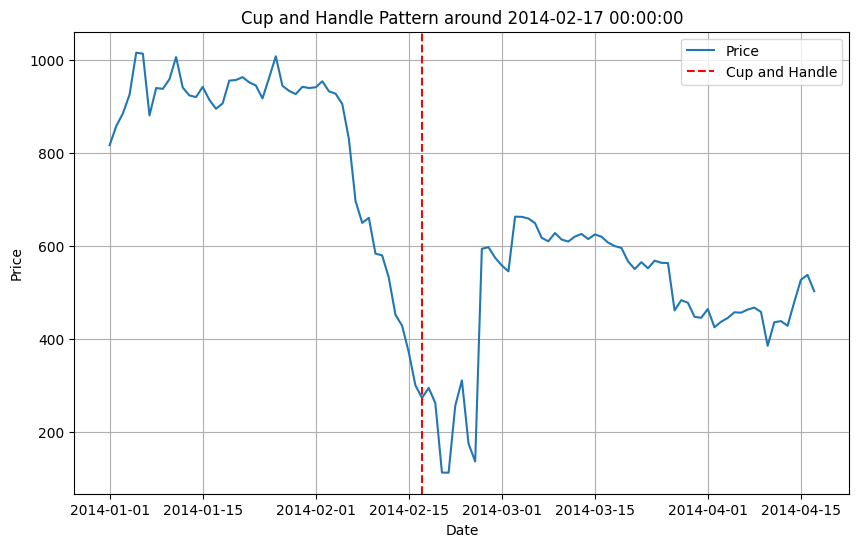

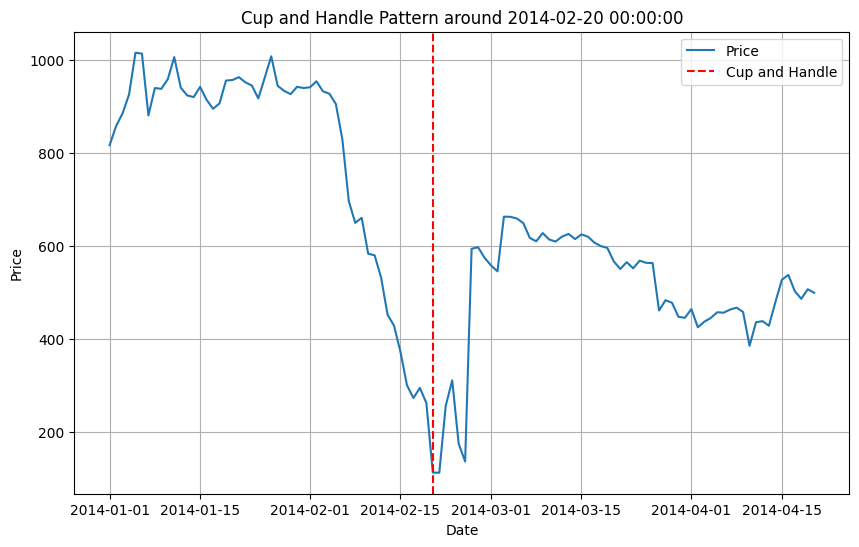

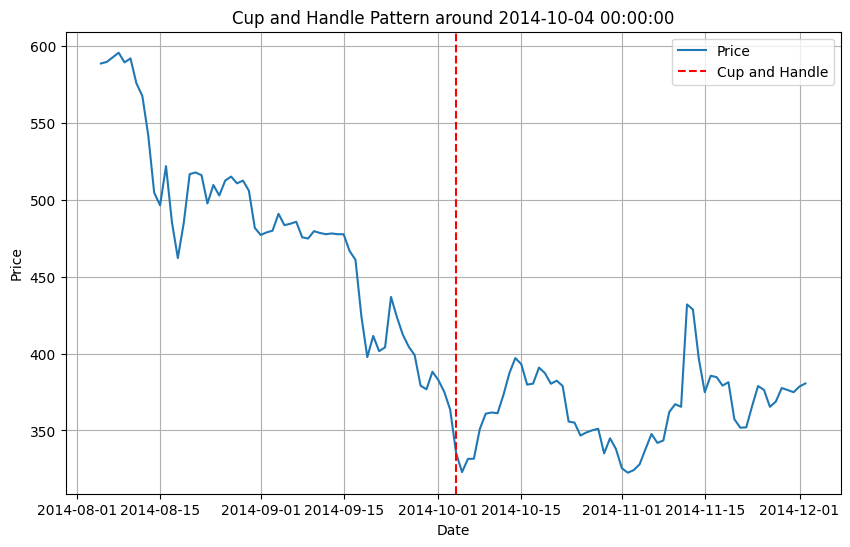

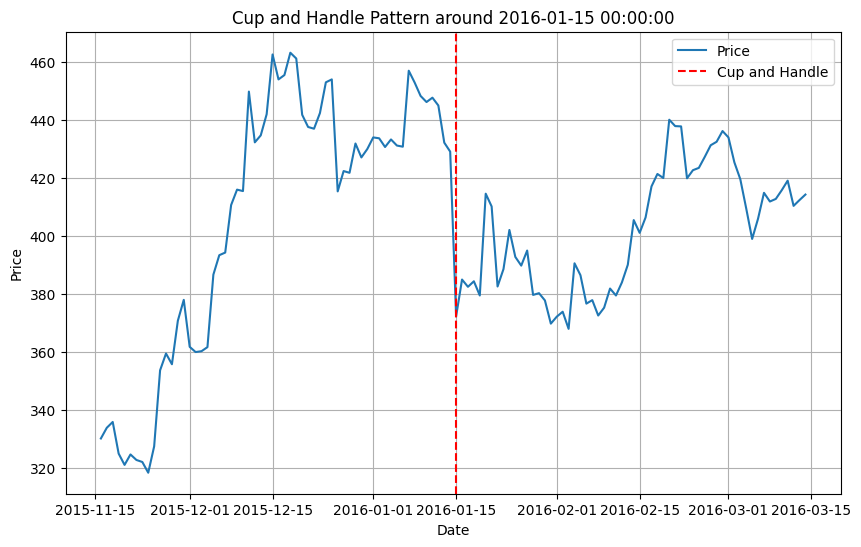

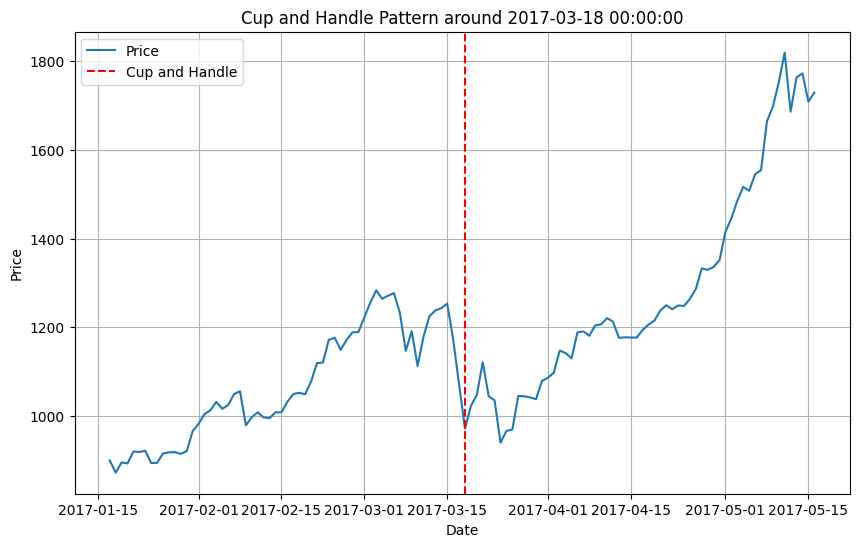

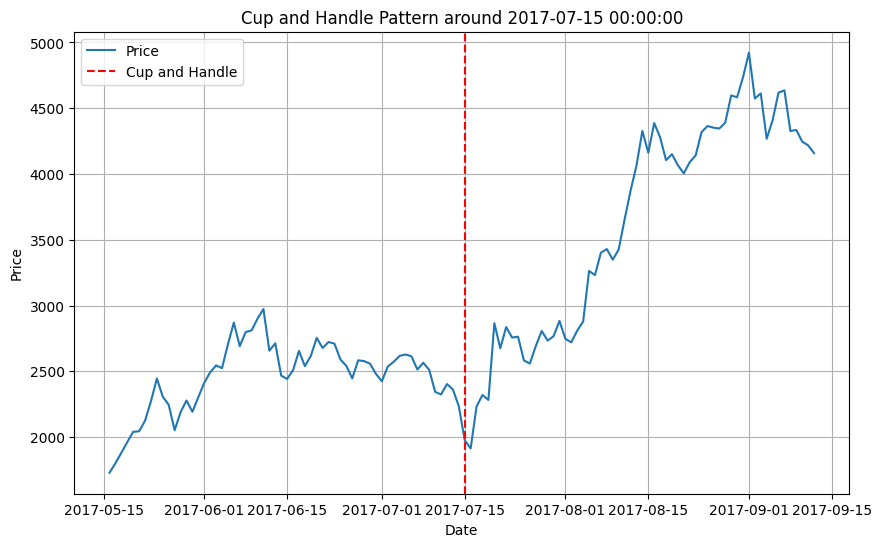

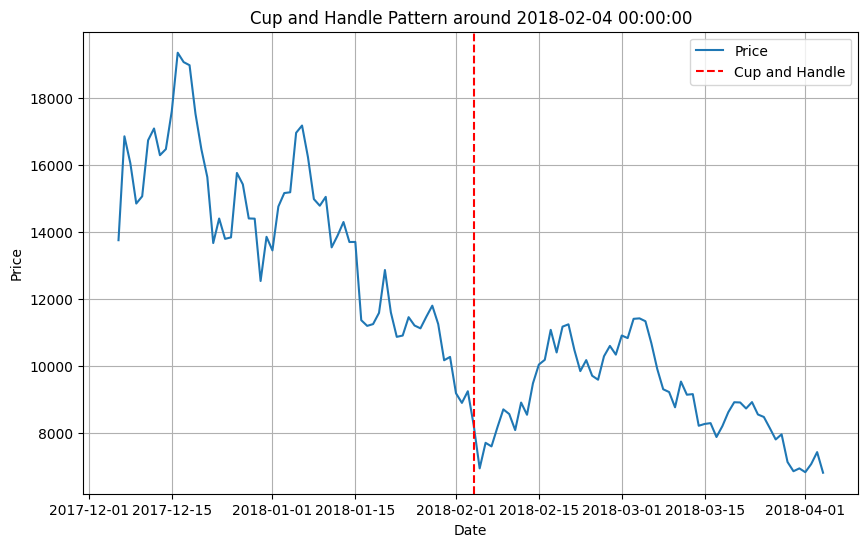

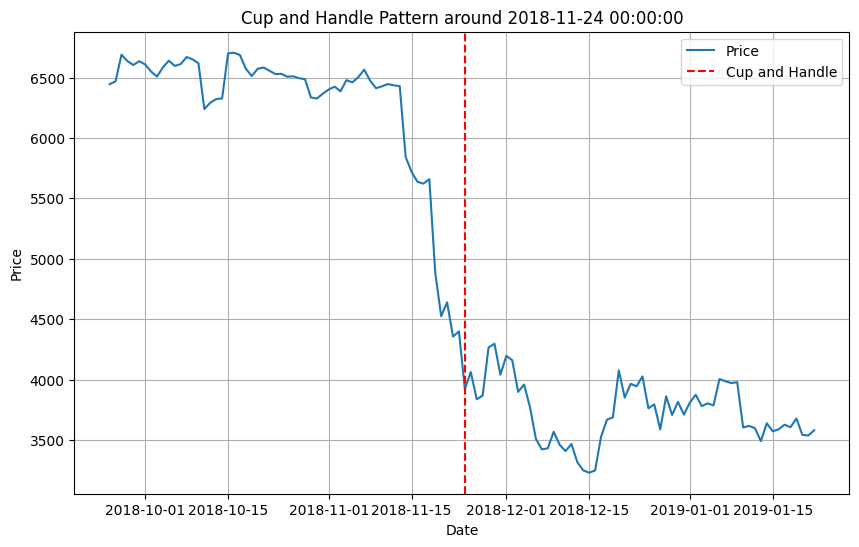

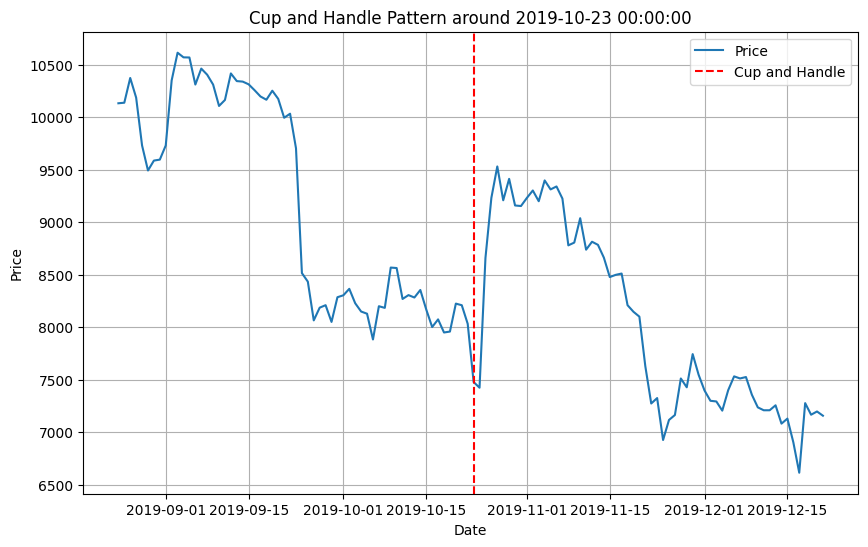

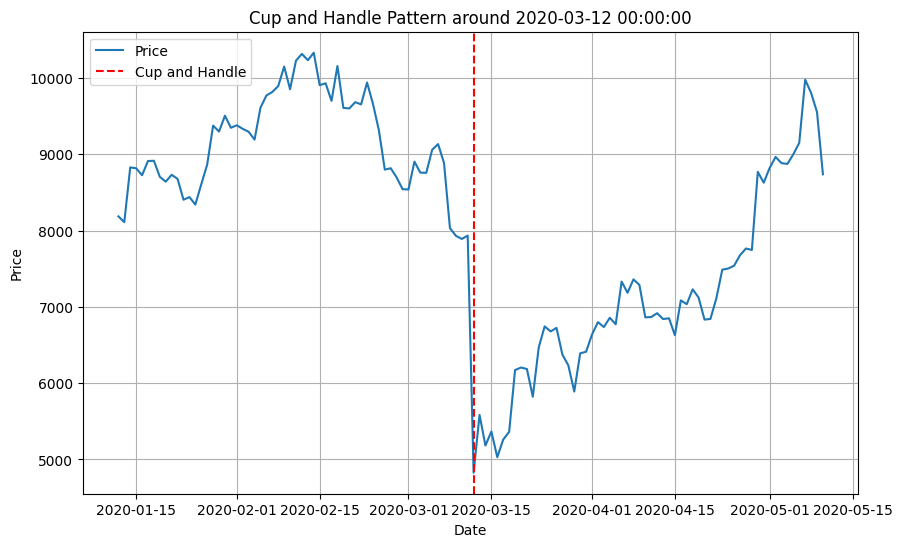

In [21]:
#Define the cup and handle pattern in the price data
def cup_and_handle_pattern(data):
    # Initialize the pattern column
    data["Cup_and_Handle"] = 0

    # Loop through the data to identify if there is a cup pattern first, the cup pattern is defined as a U shape in a perioud from 7 dayas to 30 days, 5% error is allowed.
    for i in range(30, len(data) - 7):
        # Check if the current price is lower than the previous 30 days
        if data["Price"][i] < data["Price"][i - 30:i].min() * 0.95:
            # Check if the next 7 days are higher than the current price
            if data["Price"][i + 1:i + 8].max() > data["Price"][i] * 1.05:
                # Check if the next 7 days are having a downtrend with the price around 50% of the cup height, cup height is defined as the difference between the current price and the minimum price in the last 30 days
                cup_height = data["Price"][i] - data["Price"][i - 30:i].min()
                if data["Price"][i + 1:i + 8].min() < data["Price"][i] - cup_height * 0.5:
                    # Check if the next 7 days are higher than the current price
                    if data["Price"][i + 8:i + 15].max() > data["Price"][i] * 1.05:
                        # Mark as cup and handle pattern
                        data.at[i, "Cup_and_Handle"] = 1
    return data

# Apply the function to the data
btc_data = cup_and_handle_pattern(btc_data)
# Plot the first ten cup and handle patterns with time period 60 days before and after
import matplotlib.pyplot as plt

# Find the indices of the first ten cup and handle patterns
cup_and_handle_indices = btc_data[btc_data["Cup_and_Handle"] == 1].index[:10]

# Plot each pattern
for idx in cup_and_handle_indices:
    start_idx = max(0, idx - 60)  # Ensure we don't go out of bounds
    end_idx = min(len(btc_data), idx + 60)
    pattern_data = btc_data.iloc[start_idx:end_idx]

    plt.figure(figsize=(10, 6))
    plt.plot(pattern_data["Date"], pattern_data["Price"], label="Price")
    plt.axvline(x=btc_data.iloc[idx]["Date"], color="red", linestyle="--", label="Cup and Handle")
    plt.title(f"Cup and Handle Pattern around {btc_data.iloc[idx]['Date']}")
    plt.xlabel("Date")
    plt.ylabel("Price")
    plt.legend()
    plt.grid()
    plt.show()


In [22]:
btc_data.describe().T

,count,mean,min,25%,50%,75%,max,std
Date,4112,2019-08-18 12:29:03.968871680,2014-01-01 00:00:00,2016-10-24 18:00:00,2019-08-18 12:00:00,2022-06-11 06:00:00,2025-04-05 00:00:00,NaN
Price,4112.0,20054.025705,111.6,757.225,8904.15,30785.6,106157.2,24374.790307
Open,4112.0,20033.980593,111.6,757.225,8900.7,30711.075,106157.2,24356.521149
High,4112.0,20493.344893,160.1,769.2,9167.55,31756.175,109228.6,24873.552105
Low,4112.0,19546.539178,91.7,740.175,8677.8,30080.3,105350.6,23809.08792
RSI_6,4106.0,53.013896,2.225745,39.025398,51.828787,67.153474,99.005707,19.492105
RSI_12,4100.0,52.898359,8.368179,42.533023,51.862652,62.427832,95.295275,14.895531
EMA_14,4099.0,19982.858778,225.303492,742.151171,8937.609398,31067.960349,102629.881147,24202.213612
SMA_14,4099.0,19983.288675,221.585714,745.525,8972.7,30529.564286,103573.285714,24226.272344
MACD,4087.0,145.150948,-5068.338535,-114.942437,4.921153,306.639903,7024.867129,1133.656419


In [23]:
btc_data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 4112 entries, 0 to 4111
Data columns (total 35 columns):
 #   Column                  Non-Null Count  Dtype         
---  ------                  --------------  -----         
 0   Date                    4112 non-null   datetime64[ns]
 1   Price                   4112 non-null   float64       
 2   Open                    4112 non-null   float64       
 3   High                    4112 non-null   float64       
 4   Low                     4112 non-null   float64       
               4112 non-null   object        
 6   RSI_6                   4106 non-null   float64       
 7   RSI_12                  4100 non-null   float64       
 8   EMA_14                  4099 non-null   float64       
 9   SMA_14                  4099 non-null   float64       
 10  MACD                    4087 non-null   float64       
 11  MACD_Signal             4079 non-null   float64       
 12  MACD_Hist               4079 non-null   float64       
 13  BB

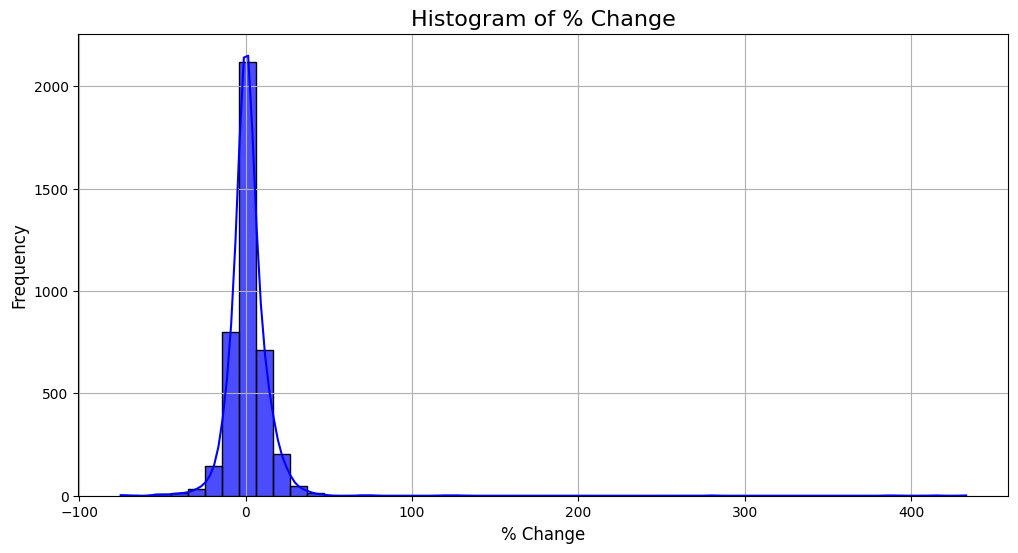

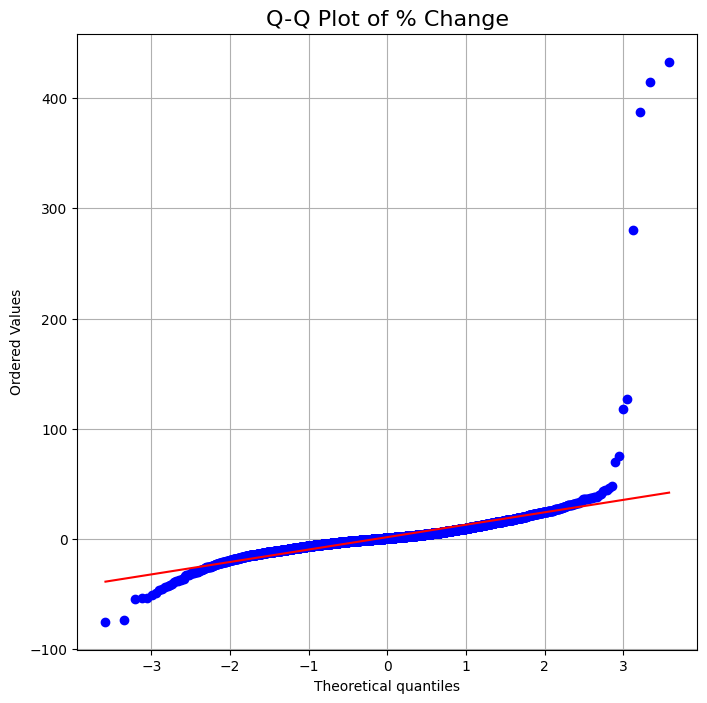

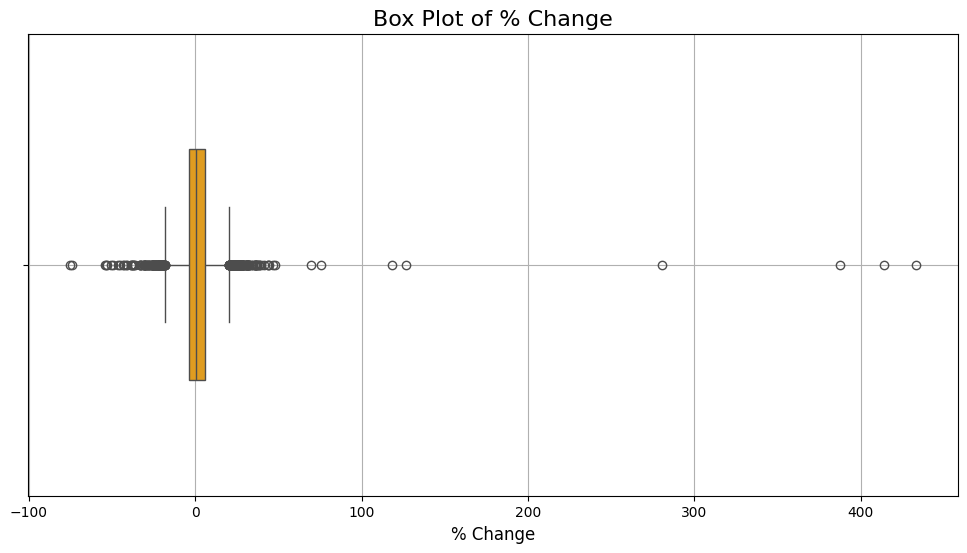

Lower Bound for Outliers: -18.22093825914128
Upper Bound for Outliers: 20.099138460649726
Number of Outliers: 272
Shapiro-Wilk Test Statistic: 0.5009, p-value: 0.0000
The data does not appear to be normally distributed (reject H0).


In [27]:
import matplotlib.pyplot as plt
import seaborn as sns
from scipy.stats import shapiro, probplot

# Drop NaN values from the 'Pct_Change' column
btc_data = btc_data.dropna(subset=['Pct_Change'])

# Histogram to plot the distribution of 'Pct_Change'
plt.figure(figsize=(12, 6))
sns.histplot(btc_data['Pct_Change'], kde=True, bins=50, color='blue', alpha=0.7)
plt.title('Histogram of % Change', fontsize=16)
plt.xlabel('% Change', fontsize=12)
plt.ylabel('Frequency', fontsize=12)
plt.grid(True)
plt.show()

# Q-Q Plot to visually check for normality
plt.figure(figsize=(8, 8))
probplot(btc_data['Pct_Change'], dist="norm", plot=plt)
plt.title('Q-Q Plot of % Change', fontsize=16)
plt.grid(True)
plt.show()

# Box Plot to check for outliers
plt.figure(figsize=(12, 6))
sns.boxplot(x=btc_data['Pct_Change'], color='orange', width=0.5)
plt.title('Box Plot of % Change', fontsize=16)
plt.xlabel('% Change', fontsize=12)
plt.grid(True)
plt.show()

# Identify Outliers based on the IQR (Interquartile Range) method
Q1 = btc_data['Pct_Change'].quantile(0.25)  # First quartile
Q3 = btc_data['Pct_Change'].quantile(0.75)  # Third quartile
IQR = Q3 - Q1  # Interquartile Range
lower_bound = Q1 - 1.5 * IQR  # Lower bound
upper_bound = Q3 + 1.5 * IQR  # Upper bound

print(f"Lower Bound for Outliers: {lower_bound}")
print(f"Upper Bound for Outliers: {upper_bound}")

# Filter outliers
outliers = btc_data[(btc_data['Pct_Change'] < lower_bound) | (btc_data['Pct_Change'] > upper_bound)]
print(f"Number of Outliers: {len(outliers)}")

# Shapiro-Wilk Test for normality
stat, p_value = shapiro(btc_data['Pct_Change'])
print(f"Shapiro-Wilk Test Statistic: {stat:.4f}, p-value: {p_value:.4f}")

# Interpretation of the Shapiro-Wilk test result
if p_value > 0.05:
    print("The data appears to be normally distributed (fail to reject H0).")
else:
    print("The data does not appear to be normally distributed (reject H0).")

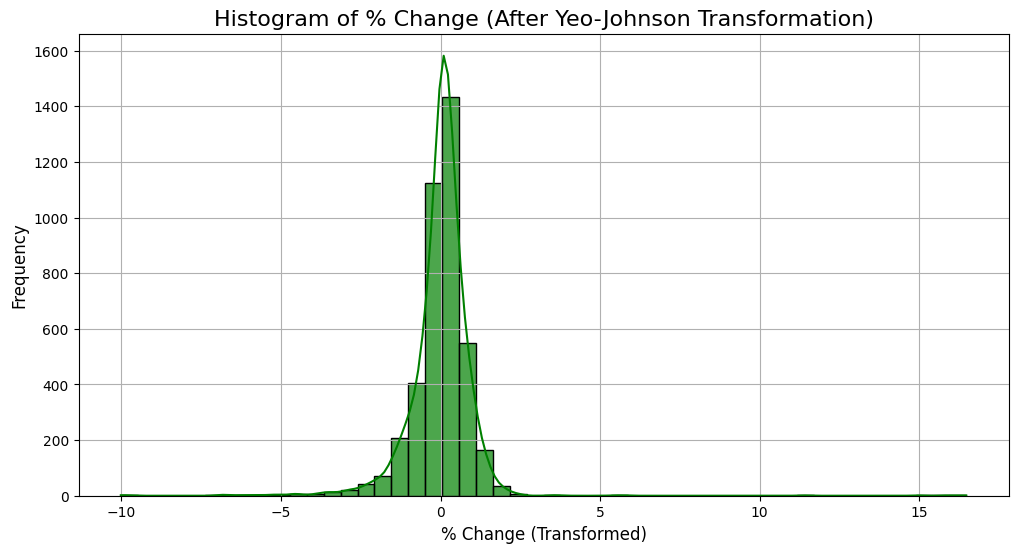

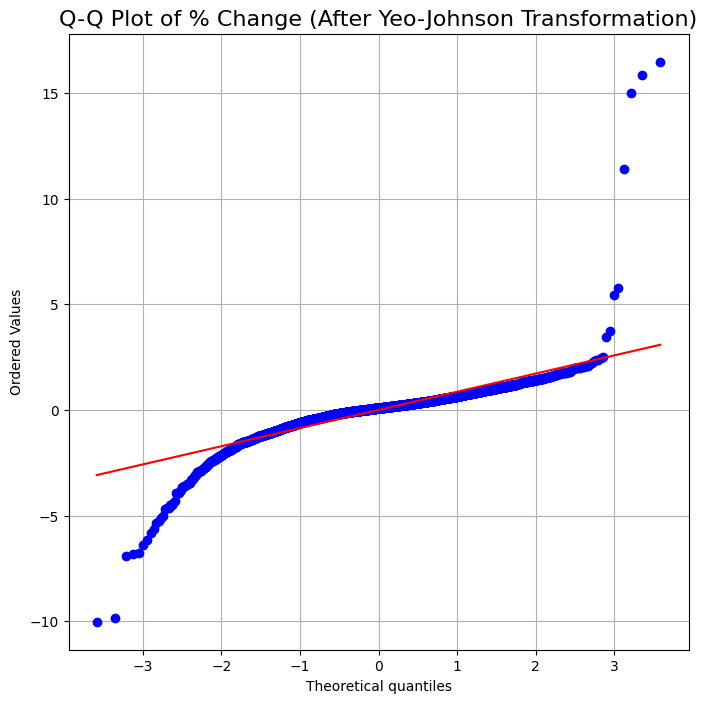

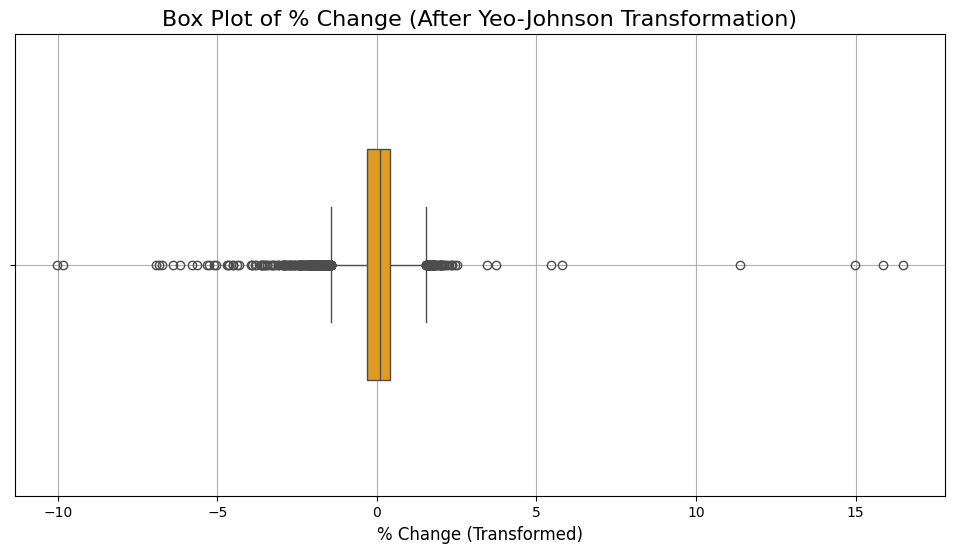

Shapiro-Wilk Test Statistic: 0.7413, p-value: 0.0000
Lower Bound for Outliers (Transformed): -1.428131344460079
Upper Bound for Outliers (Transformed): 1.5346348058134307
Number of Outliers (Transformed Data): 281


In [31]:
from sklearn.preprocessing import PowerTransformer
import matplotlib.pyplot as plt
import seaborn as sns
from scipy.stats import probplot, shapiro

# Initialize the Yeo-Johnson transformer
pt = PowerTransformer(method='yeo-johnson')

# Apply the transformation
btc_data['Pct_Change_YJ'] = pt.fit_transform(btc_data[['Pct_Change']])

# Plot the transformed data (Histogram)
plt.figure(figsize=(12, 6))
sns.histplot(btc_data['Pct_Change_YJ'], kde=True, bins=50, color='green', alpha=0.7)
plt.title('Histogram of % Change (After Yeo-Johnson Transformation)', fontsize=16)
plt.xlabel('% Change (Transformed)', fontsize=12)
plt.ylabel('Frequency', fontsize=12)
plt.grid(True)
plt.show()

# Q-Q Plot for transformed data
plt.figure(figsize=(8, 8))
probplot(btc_data['Pct_Change_YJ'], dist="norm", plot=plt)
plt.title('Q-Q Plot of % Change (After Yeo-Johnson Transformation)', fontsize=16)
plt.grid(True)
plt.show()

# Box Plot to visualize outliers after transformation
plt.figure(figsize=(12, 6))
sns.boxplot(x=btc_data['Pct_Change_YJ'], color='orange', width=0.5)
plt.title('Box Plot of % Change (After Yeo-Johnson Transformation)', fontsize=16)
plt.xlabel('% Change (Transformed)', fontsize=12)
plt.grid(True)
plt.show()

# Run Shapiro-Wilk test for normality on transformed data
stat, p_value = shapiro(btc_data['Pct_Change_YJ'])
print(f"Shapiro-Wilk Test Statistic: {stat:.4f}, p-value: {p_value:.4f}")

# Detect Outliers using the IQR method on the transformed data
Q1 = btc_data['Pct_Change_YJ'].quantile(0.25)  # First quartile
Q3 = btc_data['Pct_Change_YJ'].quantile(0.75)  # Third quartile
IQR = Q3 - Q1  # Interquartile Range
lower_bound = Q1 - 1.5 * IQR  # Lower bound
upper_bound = Q3 + 1.5 * IQR  # Upper bound

# Print the bounds for outliers
print(f"Lower Bound for Outliers (Transformed): {lower_bound}")
print(f"Upper Bound for Outliers (Transformed): {upper_bound}")

# Filter outliers
outliers = btc_data[(btc_data['Pct_Change_YJ'] < lower_bound) | (btc_data['Pct_Change_YJ'] > upper_bound)]
print(f"Number of Outliers (Transformed Data): {len(outliers)}")

# Optionally, cap or remove outliers
# Cap outliers (Winsorization)
btc_data['Pct_Change_YJ_Capped'] = btc_data['Pct_Change_YJ'].clip(lower=lower_bound, upper=upper_bound)

# Remove outliers
btc_data_no_outliers = btc_data[(btc_data['Pct_Change_YJ'] >= lower_bound) & (btc_data['Pct_Change_YJ'] <= upper_bound)]